In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [73]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [74]:
from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation

Load and Prepare data to input to LSTM model

In [75]:
filepath = "../Data/RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [76]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))

fig.update_yaxes(range=[500, 2500])

In [78]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [79]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['Close'].values, scaler)

# x_train, x_test, y_train_lstm, y_test_lstm = prep.prepare_data(data['Close'].values)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [80]:
num_clusters = 6

In [81]:
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


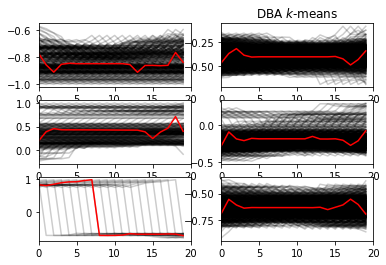

In [82]:
kmeans.visualize_clustering_results()

In [83]:
len(kmeans.labels_)

2296

In [84]:
cluster2 = (np.where(kmeans.labels_ == 2))
cluster3 = (np.where(kmeans.labels_ == 3))

In [85]:
len(cluster2[0]), type(cluster2[0])

(196, numpy.ndarray)

In [86]:
type(y_train_lstm.flatten())

torch.Tensor

In [87]:
y_train = y_train_lstm.flatten().numpy()

In [88]:
type(y_train)

numpy.ndarray

In [89]:
train_errors = pd.read_csv('../Data/LSTM_Reliance_ErrorDistribution.csv', usecols=[2])
train_errors.head()

,diff
0,14.215332
1,4.790161
2,17.534180
3,49.154175
4,20.048096


In [90]:
cluster2_y = y_train[cluster2[0]]
cluster3_y = y_train[cluster3[0]]

In [91]:
len(cluster2_y), len(cluster3_y)

(196, 490)

In [22]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# y_norm = scaler.fit_transform(cluster2_y.reshape(-1, 1))
# y_norm3 = scaler.fit_transform(cluster3_y.reshape(-1, 1))

In [23]:
np.mean(y_norm), np.mean(y_norm3)

(0.624451, 0.49819535)

In [24]:
mylist = [13,23,14,52,6,23]

np.random.choice(mylist, 3, replace=False)


array([14, 52, 23])

In [64]:
y = scaler.inverse_transform(kmeans.cluster_centers_[2].flatten().reshape(-1,1))

In [66]:
from scipy.integrate import simps
from numpy import trapz


# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array([5, 20, 4, 18, 19, 18, 7, 4])

# y = scaler.inverse_transform(kmeans.cluster_centers_[2].flatten().reshape(-1,1))
# y = kmeans.cluster_centers_[2].flatten()

# Compute the area using the composite trapezoidal rule.
area = trapz(y.flatten(), dx=3)
print("area =", area)

# Compute the area using the composite Simpson's rule.
area = simps(y.flatten(), dx=3)
print("area =", area)

area = 78759.10156682806
area = 78860.45763549689


In [26]:
# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array([5, 20, 4, 18, 19, 18, 7, 4])

y = kmeans.cluster_centers_[3].flatten()

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=3)
print("area =", area)

# Compute the area using the composite Simpson's rule.
area = simps(y, dx=3)
print("area =", area)

area = 59559.12645290591
area = 59564.70649086065


In [27]:
kmeans.cluster_centers_[2].flatten()

array([1263.69229   , 1384.38677373, 1379.50358794, 1349.41969349,
       1385.95747618, 1385.52126077, 1385.06869079, 1384.56752257,
       1384.01214885, 1382.65794244, 1382.24439503, 1382.1976712 ,
       1401.21822643, 1381.30654308, 1380.49788887, 1359.44236116,
       1378.0798375 , 1393.85567869, 1522.40994465, 1237.680152  ])

In [28]:
train_preds = kmeans.predict(x_train)

In [31]:
# for i in range(num_clusters):
#     print(f"cluster {i}- {len(x_train[y_pred == i])}")

In [32]:
model = torch.load('lstm_rel.pt')
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [67]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.05 MAPE
R-squared value is 0.8750267415343719
RMSE:  129.89433806944783


x_train[y_pred == ]

#### Predict the cluster for forecast data

In [68]:
#prepare forecasts for clustering

preds = y_test_pred[:,0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [69]:
res = kmeans.predict(forecasts)

In [70]:
res

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [37]:
np.where(res == 6)

(array([], dtype=int64),)

In [38]:
# forecasts_df = pd.DataFrame({'forecasts': preds_inv.flatten(),
#                             'gt': y_test[:,0]})
# forecasts_df.head()

In [39]:
forecasts_df.tail()

NameError: name 'forecasts_df' is not defined

In [ ]:
len(forecasts_df)

559

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecasts_df.index, y=forecasts_df['gt'], mode='lines', name='gt'))
fig.add_trace(go.Scatter(x=forecasts_df.index, y=forecasts_df['forecasts'], mode='lines', name='forecasts'))

In [71]:
t = [130, 184, 244, 225, 160, 235, 175, 30, 264, 380]
kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res)

,test values,mean,cluster_assigned,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,130,1527.979370,2,7.151244,19.95,236029.303020,1.0,1.0,743747.760871
1,184,1202.193604,2,7.151244,19.95,189910.904164,1.0,1.0,584451.384309
2,244,1556.060547,2,7.151244,19.95,242679.311079,1.0,1.0,757420.210871
3,225,1454.129639,2,7.151244,19.95,225664.735658,1.0,1.0,707502.988996
4,160,1449.835205,2,7.151244,19.95,224614.577946,1.0,1.0,705662.823371
5,235,1475.690308,2,7.151244,19.95,229418.385088,1.0,1.0,718417.701496
6,175,1396.619995,2,7.151244,19.95,216732.037354,1.0,1.0,679897.285871
7,30,1239.786987,2,7.151244,19.95,191874.433681,1.0,1.0,603547.567121
8,264,1740.570923,2,7.151244,19.95,269634.377451,1.0,1.0,847248.092121
9,380,1854.095337,2,7.151244,19.95,285840.195412,1.0,1.0,902675.792121


In [ ]:

# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array([5, 20, 4, 18, 19, 18, 7, 4])

y = forecasts[380].flatten()

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=3)
print("area =", area)

# Compute the area using the composite Simpson's rule.
area = simps(y, dx=3)
print("area =", area)

area = 41.958702
area = 41.96242541074753


In [ ]:
y = forecasts[160].flatten()

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=3)
print("area =", area)

# Compute the area using the composite Simpson's rule.
area = simps(y, dx=3)
print("area =", area)

area = 8.128518
area = 8.12142026424408


In [ ]:
for i in t:
    y = forecasts[i].flatten()

    print('i', i)
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y, dx=3)
    print("trapz area =", area)

    # Compute the area using the composite Simpson's rule.
    area = simps(y, dx=3)
    print("simps area =", area)


i 130
trapz area = 14.8892975
simps area = 14.893232606351376
i 184
trapz area = -12.239592
simps area = -12.24301478266716
i 244
trapz area = 17.12713
simps area = 17.131208926439285
i 225
trapz area = 8.752529
simps area = 8.748935140669346
i 160
trapz area = 8.128518
simps area = 8.12142026424408
i 235
trapz area = 10.288571
simps area = 10.273483380675316
i 175
trapz area = 4.2183294
simps area = 4.249216765165329
i 30
trapz area = -8.98976
simps area = -8.981442261487246
i 264
trapz area = 32.41845
simps area = 32.405018374323845
i 380
trapz area = 41.958702
simps area = 41.96242541074753


#### Compute mean relative change for different test sequences

In [ ]:
result

,test values,mean,cluster_assigned,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,130,0.753927,2,6.603119,18.45,35.363226,0.95,0.95,94.238987
1,184,0.071226,3,3.449505,8.55,60.299604,0.50,0.90,144.047417
2,244,0.803018,2,6.153222,17.20,47.461033,0.90,0.90,118.580924
3,225,0.601027,2,2.704416,7.35,12.836805,0.55,0.80,24.927279
4,160,0.594363,2,2.787940,7.80,11.228589,0.55,0.65,25.039893
5,235,0.643792,2,2.836994,7.55,20.705640,0.55,0.80,46.216320
6,175,0.480606,2,2.620233,6.55,24.291959,0.35,0.70,53.322738
7,30,0.152001,3,3.172500,8.35,19.691071,0.60,0.75,52.626564
8,264,1.167042,2,7.045834,19.75,100.953611,1.00,1.00,295.260087
9,380,1.391409,2,7.045834,19.75,133.054509,1.00,1.00,405.134690


<p> As there is an increase in the mean (trend) in data after 260th timestamp, the relative change in mean of forecast distribution is decreasing compared to that of relative change in mean of actual values. This difference here is computed based on shape and statistical properties of forecasts distributions. For these data points, the assigned clusters in actual values and forecasts is the same. </p>

We should check for data points, where the assigned clusters could be different.

(0.0, 20.0)

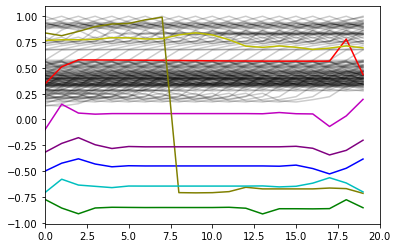

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(130, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()


(0.0, 20.0)

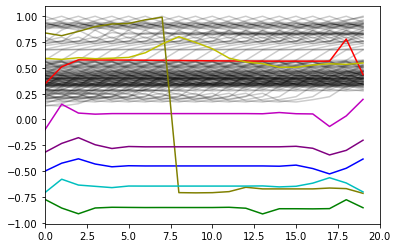

In [ ]:
# plot forecasts[225]
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(225, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

(0.0, 20.0)

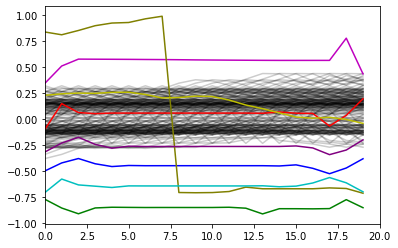

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(30, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[2].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(380, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

(0.0, 20.0)

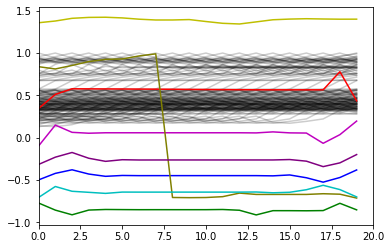

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(380, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

In [ ]:
tests_std_var['max var diff'] = (tests_std_var['variance'] - tests_std_var['cluster variance'])
tests_std_var['var reltive change'] = tests_std_var['max var diff'] / abs(tests_std_var['cluster variance'])
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance,max std diff,std reltive change,max var diff,var reltive change
0,130,0.757815,0.052477,0.002754,2,0.559415,0.149101,0.022231,-0.096624,-0.648043,-0.019477,-0.876126
1,184,0.077356,0.338947,0.114885,3,0.053535,0.212500,0.045156,0.126447,0.595046,0.069729,1.544172
2,244,0.816088,0.151176,0.022854,2,0.559415,0.149101,0.022231,0.002075,0.013917,0.000623,0.028028
3,225,0.593933,0.085164,0.007253,2,0.559415,0.149101,0.022231,-0.063937,-0.428818,-0.014978,-0.673751
4,160,0.594790,0.086670,0.007512,2,0.559415,0.149101,0.022231,-0.062430,-0.418712,-0.014719,-0.662104
5,235,0.641733,0.112858,0.012737,2,0.559415,0.149101,0.022231,-0.036243,-0.243074,-0.009494,-0.427064
6,175,0.475399,0.165178,0.027284,2,0.559415,0.149101,0.022231,0.016077,0.107828,0.005053,0.227283
7,30,0.153387,0.099002,0.009801,3,0.053535,0.212500,0.045156,-0.113498,-0.534110,-0.035355,-0.782946
8,264,1.209300,0.125740,0.015811,2,0.559415,0.149101,0.022231,-0.023360,-0.156675,-0.006420,-0.288803
9,380,1.475338,0.031657,0.001002,2,0.559415,0.149101,0.022231,-0.117444,-0.787681,-0.021229,-0.954921


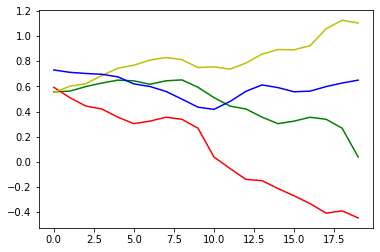

In [ ]:
plt.plot(forecasts[175], 'g')
plt.plot(forecasts[184], 'r')
plt.plot(forecasts[244], 'y')
plt.plot(forecasts[160], 'b')

### Create a synthetic time sequence of 20 timesteps with high standard deviation (sudden jump)

In [ ]:
t1 = np.arange(-1.0, -0.5, 0.05)
np.append(t1, 1)
len(t1)

10

In [ ]:
t2 = np.arange(1.1, 1.6, 0.05)
len(t2)

10

In [ ]:
final = np.concatenate((t1,t2))
final

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,
        1.5 ,  1.55])

In [ ]:
len(final)

20

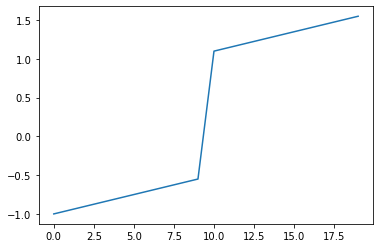

In [ ]:
plt.plot(final)

In [ ]:
np.std(final), np.mean(final), np.var(final)

(1.0597759197113323, 0.27500000000000024, 1.1231250000000002)

In [ ]:
final = final.reshape(-1, 20, 1)

In [ ]:
final_cluster = kmeans.predict(final)

In [ ]:
final_cluster

array([2])

#### Compute the relative change in mean, std, var for this synthetic data point that has a sudden jump (therefore, high std).

In [ ]:
mean_final =(np.mean(final) - tests_std_var['cluster_mean'][0]) / abs(tests_std_var['cluster_mean'][0])
std_final = ((np.std(final) - tests_std_var['cluster std'][0])) / abs(tests_std_var['cluster std'][0])
variance_final = ((np.var(final) - tests_std_var['cluster variance'][0])) / abs(tests_std_var['cluster variance'][0])

In [ ]:
print("mean of synthetic time sequence:", mean_final)
print("std of synthetic time sequence:", std_final)
print("variance of synthetic time sequence:", variance_final)

mean of synthetic time sequence: -0.508414696544433
std of synthetic time sequence: 6.107783930291172
variance of synthetic time sequence: 49.52059417881317


### Create another time sequence with sudden fall in values

In [ ]:
t2 = np.arange(1, 0.8, -0.025)
len(t2)

8

In [ ]:
t2


array([1.   , 0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825])

In [ ]:
t2 = np.append(t2, -0.8)

In [ ]:
t1 = np.arange(-0.75, -0.64, 0.01)
len(t1)

11

In [ ]:
t1

array([-0.75, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67,
       -0.66, -0.65])

In [ ]:
final_down = np.concatenate((t2, t1))
final_down

array([ 1.   ,  0.975,  0.95 ,  0.925,  0.9  ,  0.875,  0.85 ,  0.825,
       -0.8  , -0.75 , -0.74 , -0.73 , -0.72 , -0.71 , -0.7  , -0.69 ,
       -0.68 , -0.67 , -0.66 , -0.65 ])

In [ ]:
len(final_down)

20

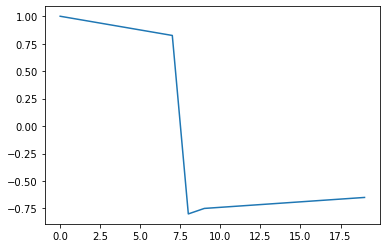

In [ ]:
plt.plot(final_down)

In [ ]:
final_down = final_down.reshape(-1, 20, 1)

In [ ]:
final_down_cluster = dba_km.predict(final_down)
final_down_cluster

array([4])

In [ ]:
cluster4_mean = np.mean(dba_km.cluster_centers_[4])
cluster4 = x_train[y_pred == 4]
cluster4 =  np.array(cluster4)

std = np.std(cluster4, axis=1)
var = np.var(cluster4, axis=1)

std = std.flatten()
var = var.flatten()

std_max_index = np.argmax(std)
std_max = std.max()

var_max_index = np.argmax(var)
var_max = var.max()


In [ ]:
np.mean(final_down), cluster4_mean

(-0.06000000000000001, -0.05033888109317528)

In [ ]:
mean_final_down = ((np.mean(final_down)) - cluster4_mean) / abs(cluster4_mean)
std_final_down = (np.std(final_down) - std_max) / abs(std_max)
variance_final_down = (np.var(final_down) - var_max) / abs(var_max)

In [ ]:
print("mean of synthetic time sequence:", mean_final_down)
print("std of synthetic time sequence:", std_final_down)
print("variance of synthetic time sequence:", variance_final_down)

mean of synthetic time sequence: -0.1919216060631618
std of synthetic time sequence: 0.021805077864399593
variance of synthetic time sequence: 0.044085643913221895
